In [1]:
import h2o
import matplotlib as plt
%matplotlib inline

from h2o.automl import H2OAutoML

import shap


In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/fujinhuizi/Desktop/insurance_ml/insurance_ml/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9r/8c_k_4cj5571k3ct1nx0vtth0000gn/T/tmpf3u0isqe
  JVM stdout: /var/folders/9r/8c_k_4cj5571k3ct1nx0vtth0000gn/T/tmpf3u0isqe/h2o_fujinhuizi_started_from_python.out
  JVM stderr: /var/folders/9r/8c_k_4cj5571k3ct1nx0vtth0000gn/T/tmpf3u0isqe/h2o_fujinhuizi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 29 days
H2O_cluster_name:,H2O_from_python_fujinhuizi_ssyn5m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
insurance = h2o.import_file('./data/motor_veh_ins_data_cleaned.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
train, test = insurance.split_frame([0.7], seed=1234)

In [5]:
print("train:%d test:%d" % (train.nrows, test.nrows))

train:73939 test:31616


In [6]:
# Severity Model
y = "Cost_claims_year"
# ignore = ["Type_risk", "Area", "Second_driver", "Value_vehicle","Power","N_doors","Type_fuel","Length","Weight"] 
ignore = ["ID", "Premium", "Length", "N_claims_year","birth_year"] 
x = list(set(train.names) - set(ignore))

In [7]:
aml = H2OAutoML(max_models =15,
		seed =12345)

In [8]:
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [9]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20240512_200754,1610.97,2.59521e+06,201.321,nan,2.59521e+06
GBM_1_AutoML_1_20240512_200754,1611.31,2.59633e+06,201.161,nan,2.59633e+06
StackedEnsemble_AllModels_1_AutoML_1_20240512_200754,1612.81,2.60115e+06,200.689,nan,2.60115e+06
DeepLearning_1_AutoML_1_20240512_200754,1614.86,2.60776e+06,192.925,nan,2.60776e+06
GBM_2_AutoML_1_20240512_200754,1627.24,2.6479e+06,203.87,nan,2.6479e+06
GBM_3_AutoML_1_20240512_200754,1627.83,2.64984e+06,205.014,nan,2.64984e+06
GBM_4_AutoML_1_20240512_200754,1631.53,2.6619e+06,205.762,nan,2.6619e+06
GLM_1_AutoML_1_20240512_200754,1635.97,2.67639e+06,256.354,4.58024,2.67639e+06
GBM_grid_1_AutoML_1_20240512_200754_model_1,1652.81,2.73179e+06,218.052,nan,2.73179e+06
XGBoost_grid_1_AutoML_1_20240512_200754_model_2,1687.87,2.84891e+06,281.352,nan,2.84891e+06


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20240512_200754,970.987,942816,227.058,nan,942816,2940,0.00611,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240512_200754,971.001,942843,227.324,nan,942843,1781,0.011113,StackedEnsemble
GBM_1_AutoML_1_20240512_200754,973.647,947989,206.887,nan,947989,1849,0.002373,GBM
DeepLearning_1_AutoML_1_20240512_200754,974.841,950315,232.921,nan,950315,2552,0.000674,DeepLearning
GBM_3_AutoML_1_20240512_200754,1000.25,1.0005e+06,211.063,nan,1.0005e+06,635,0.001589,GBM
GBM_2_AutoML_1_20240512_200754,1003.81,1.00764e+06,210.633,nan,1.00764e+06,427,0.001405,GBM
GBM_4_AutoML_1_20240512_200754,1004.18,1.00838e+06,211.654,nan,1.00838e+06,659,0.002527,GBM
GLM_1_AutoML_1_20240512_200754,1012.63,1.02542e+06,262.262,4.58082,1.02542e+06,200,0.000211,GLM
GBM_grid_1_AutoML_1_20240512_200754_model_1,1027.76,1.05629e+06,222.776,nan,1.05629e+06,1175,0.002428,GBM
XGBoost_3_AutoML_1_20240512_200754,1057.35,1.11798e+06,225.242,nan,1.11798e+06,2251,0.000433,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

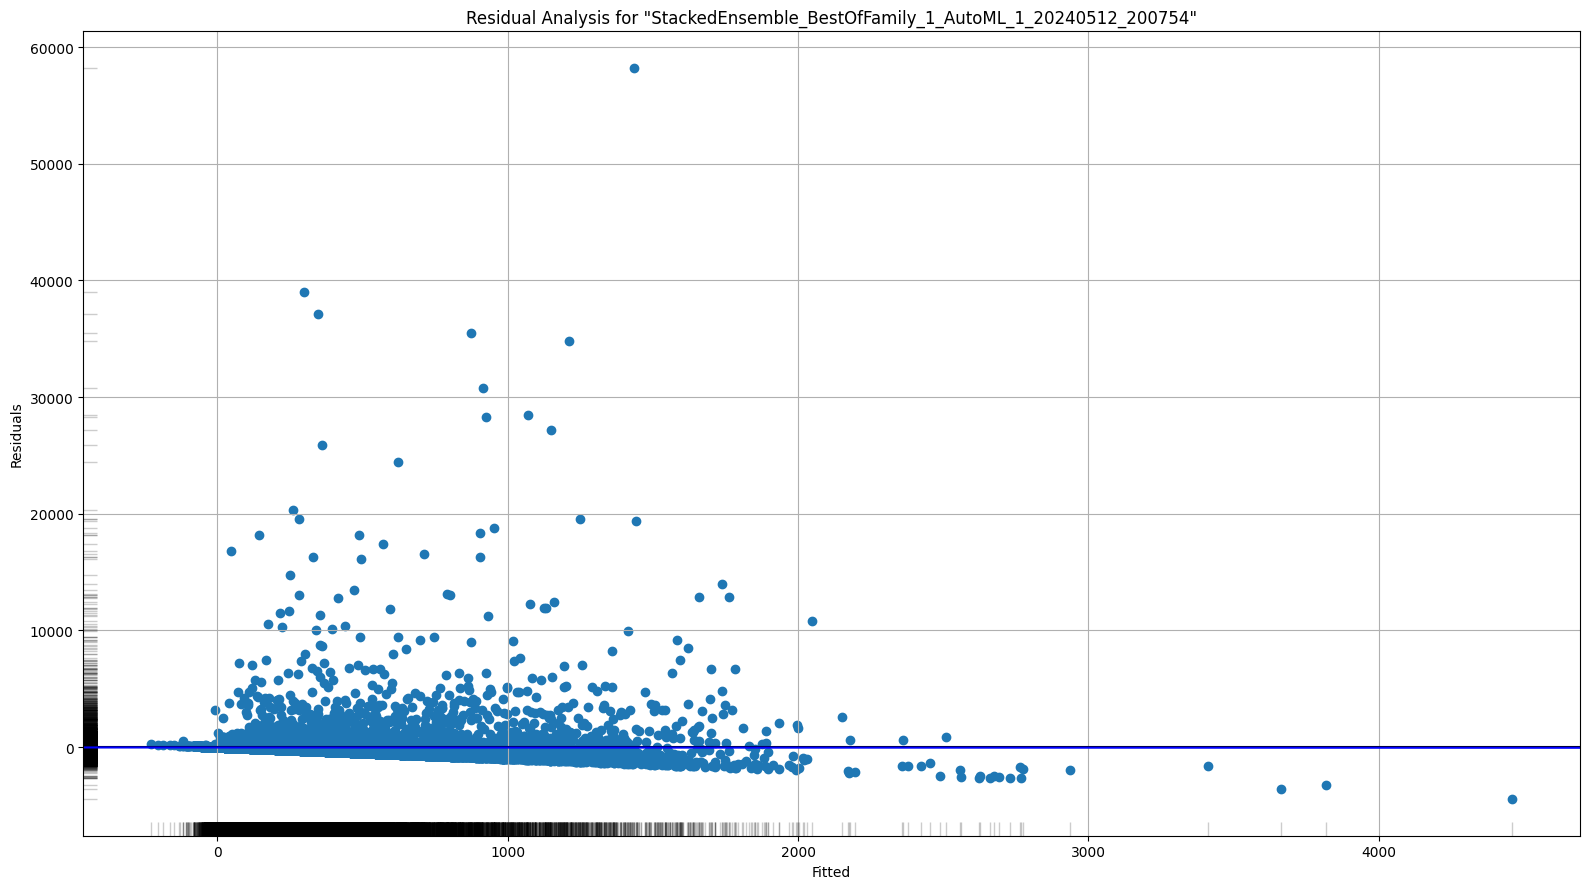

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

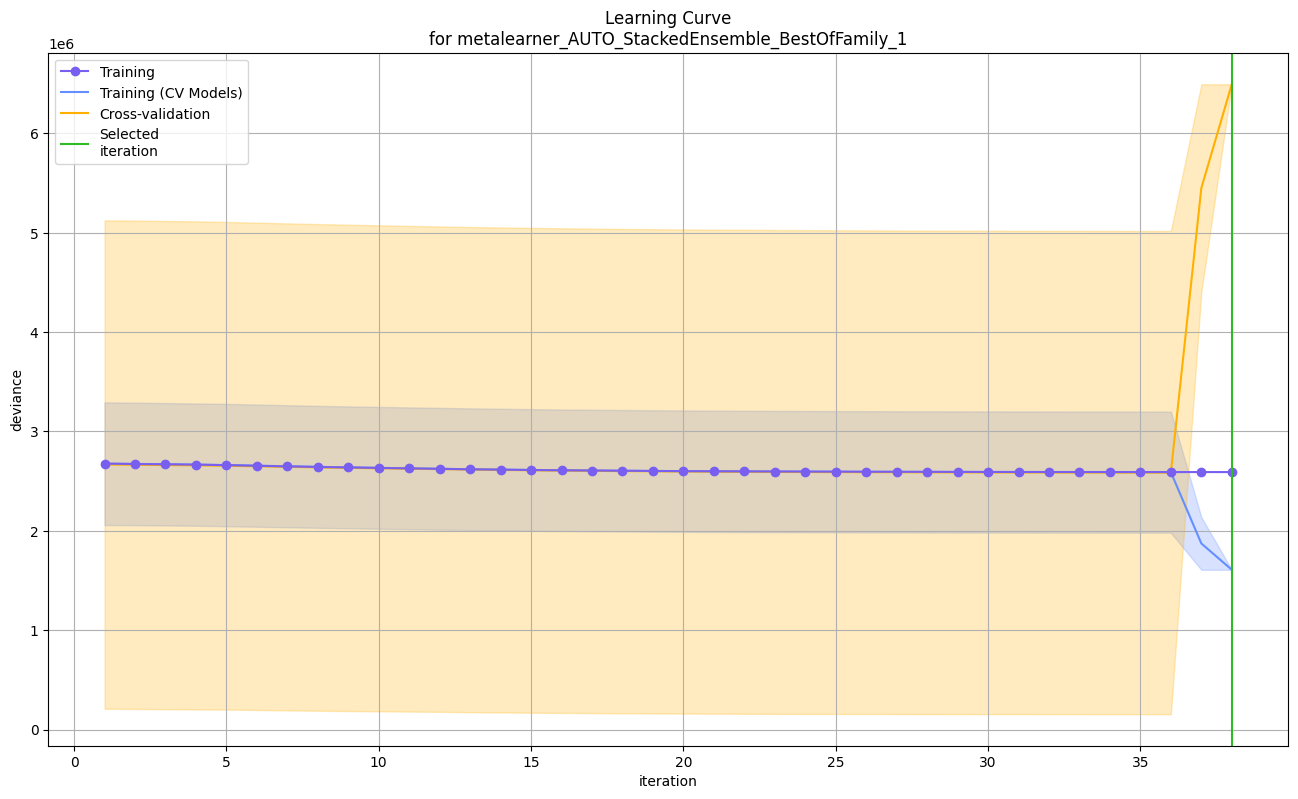

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

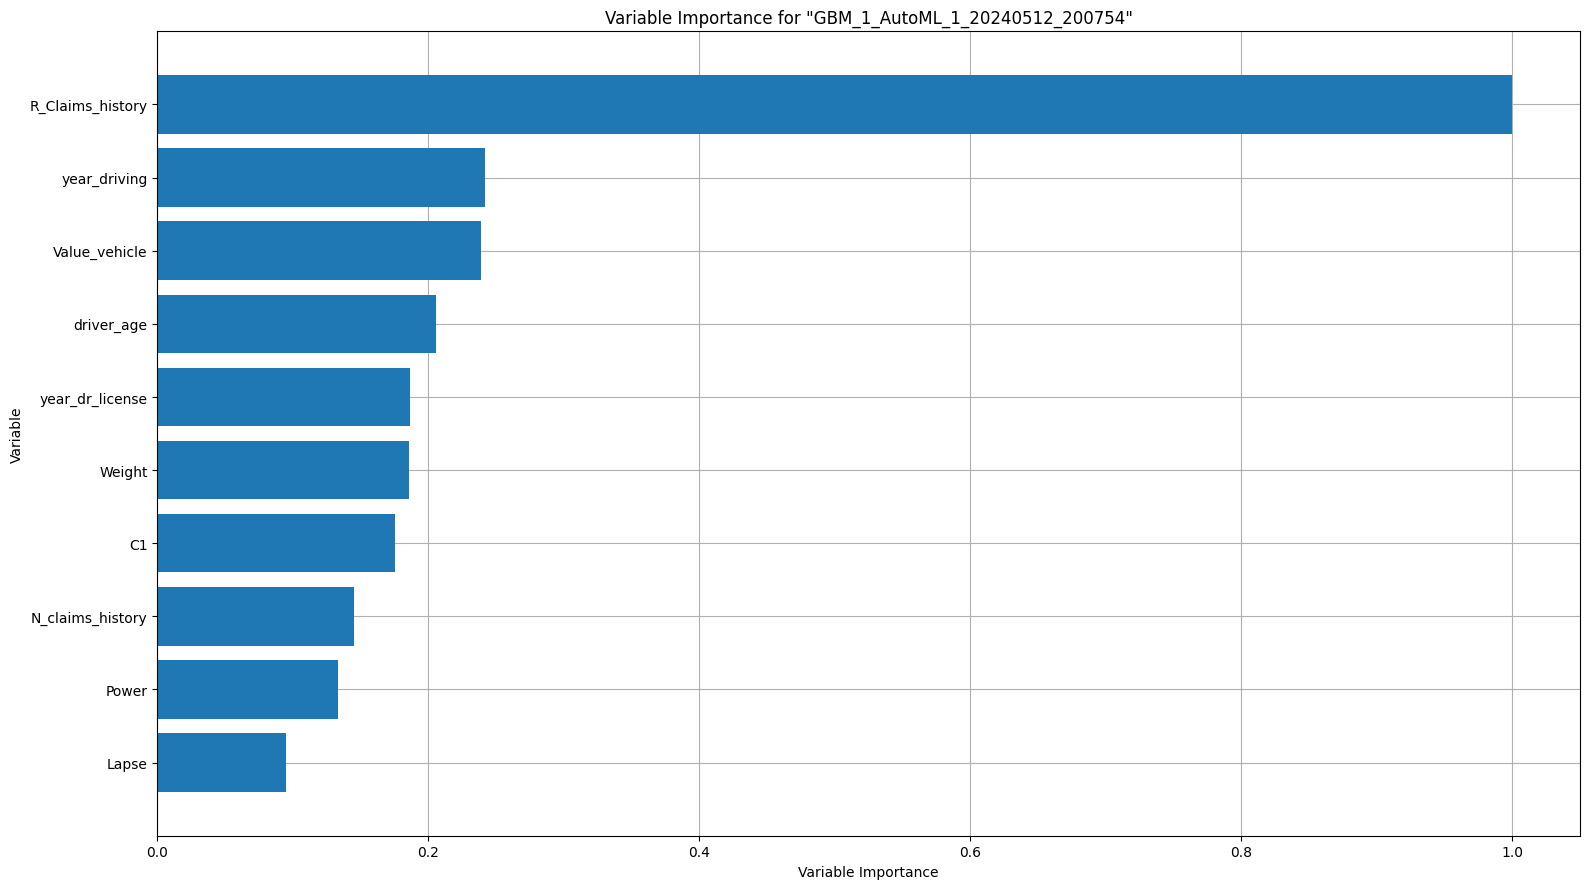

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

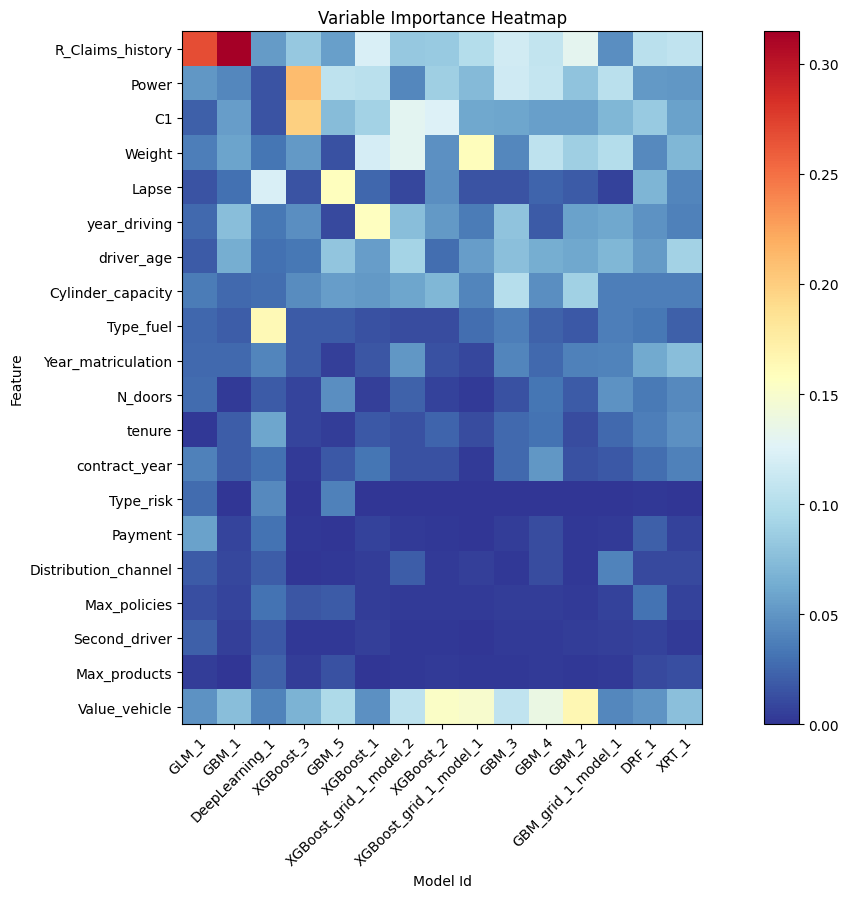

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

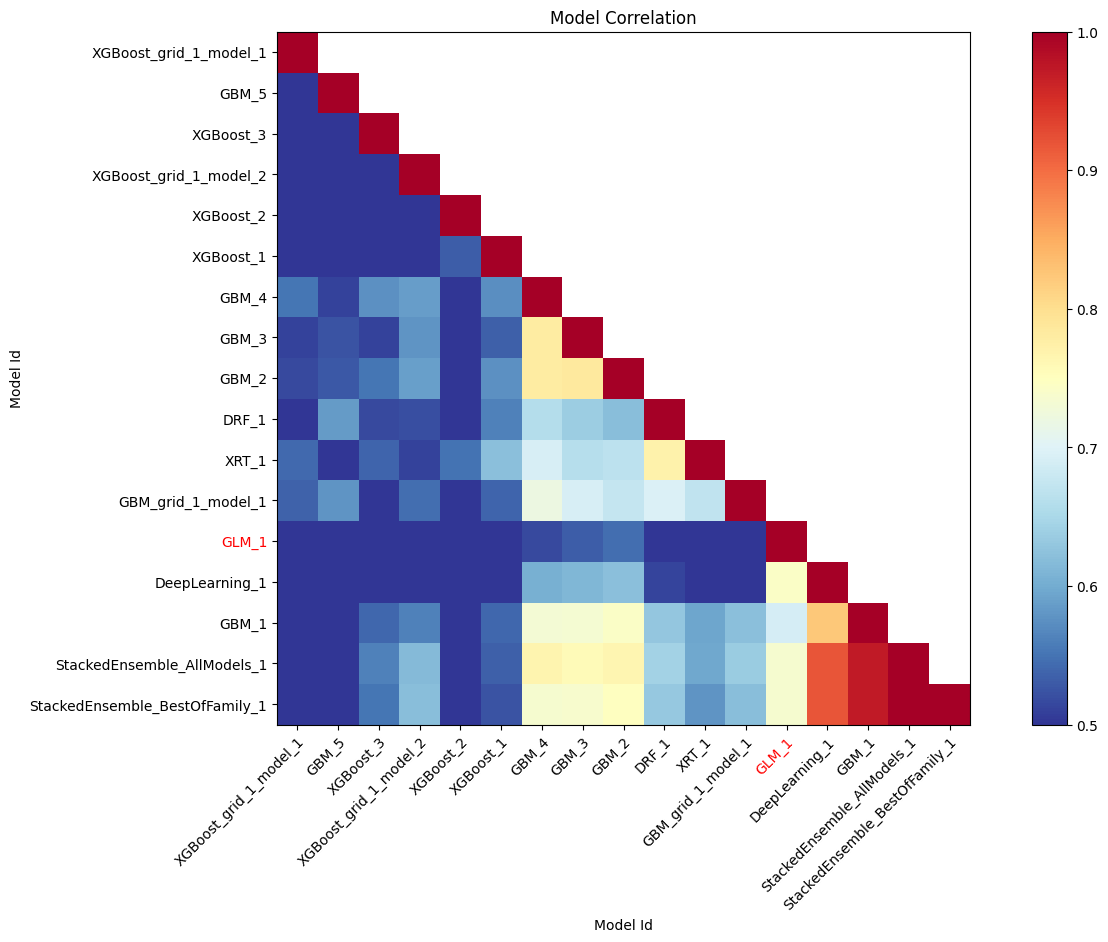

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

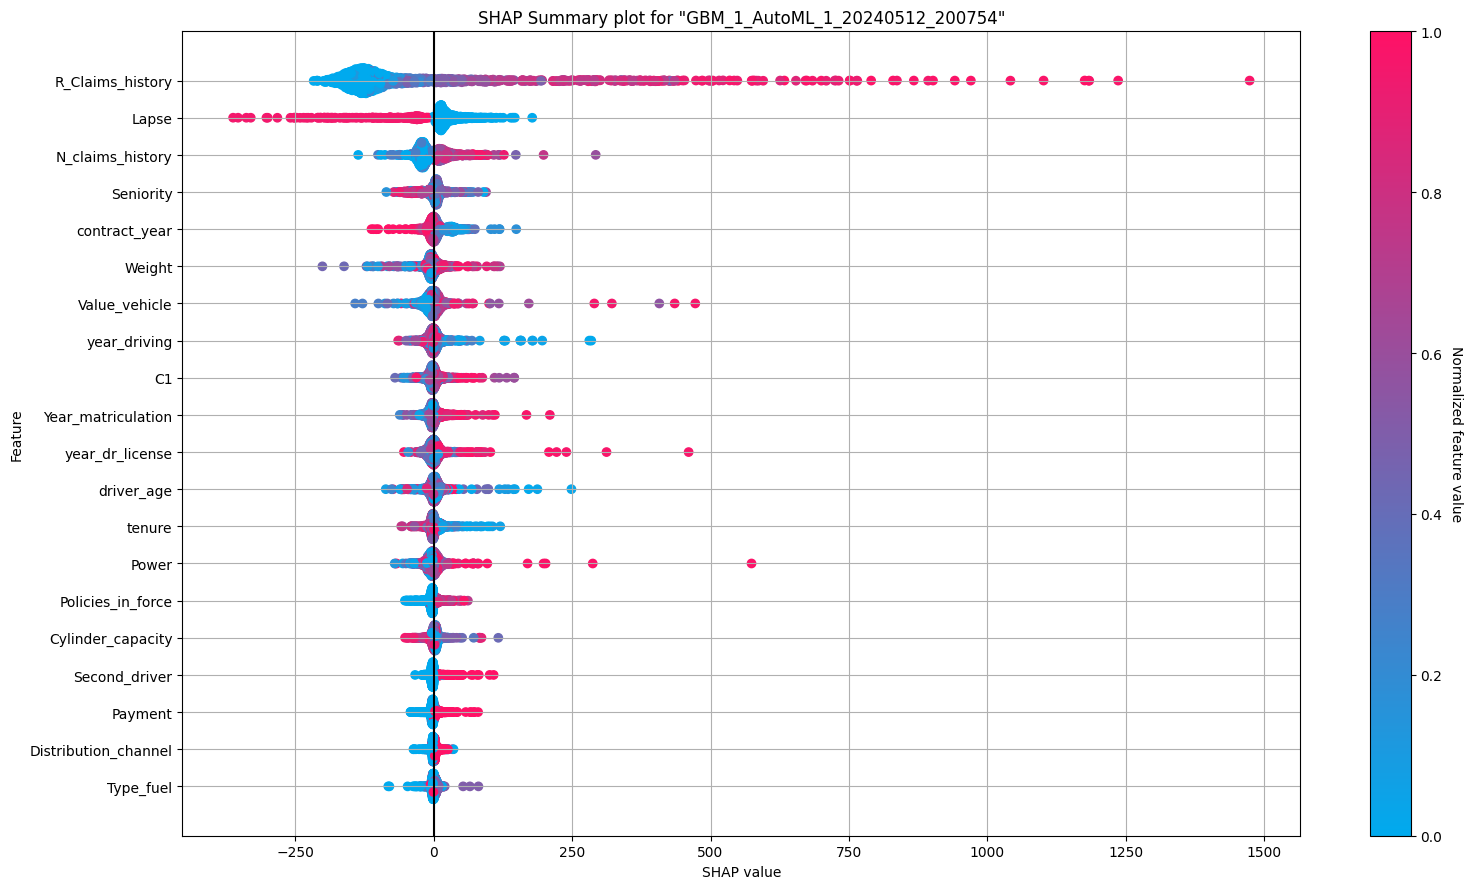

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

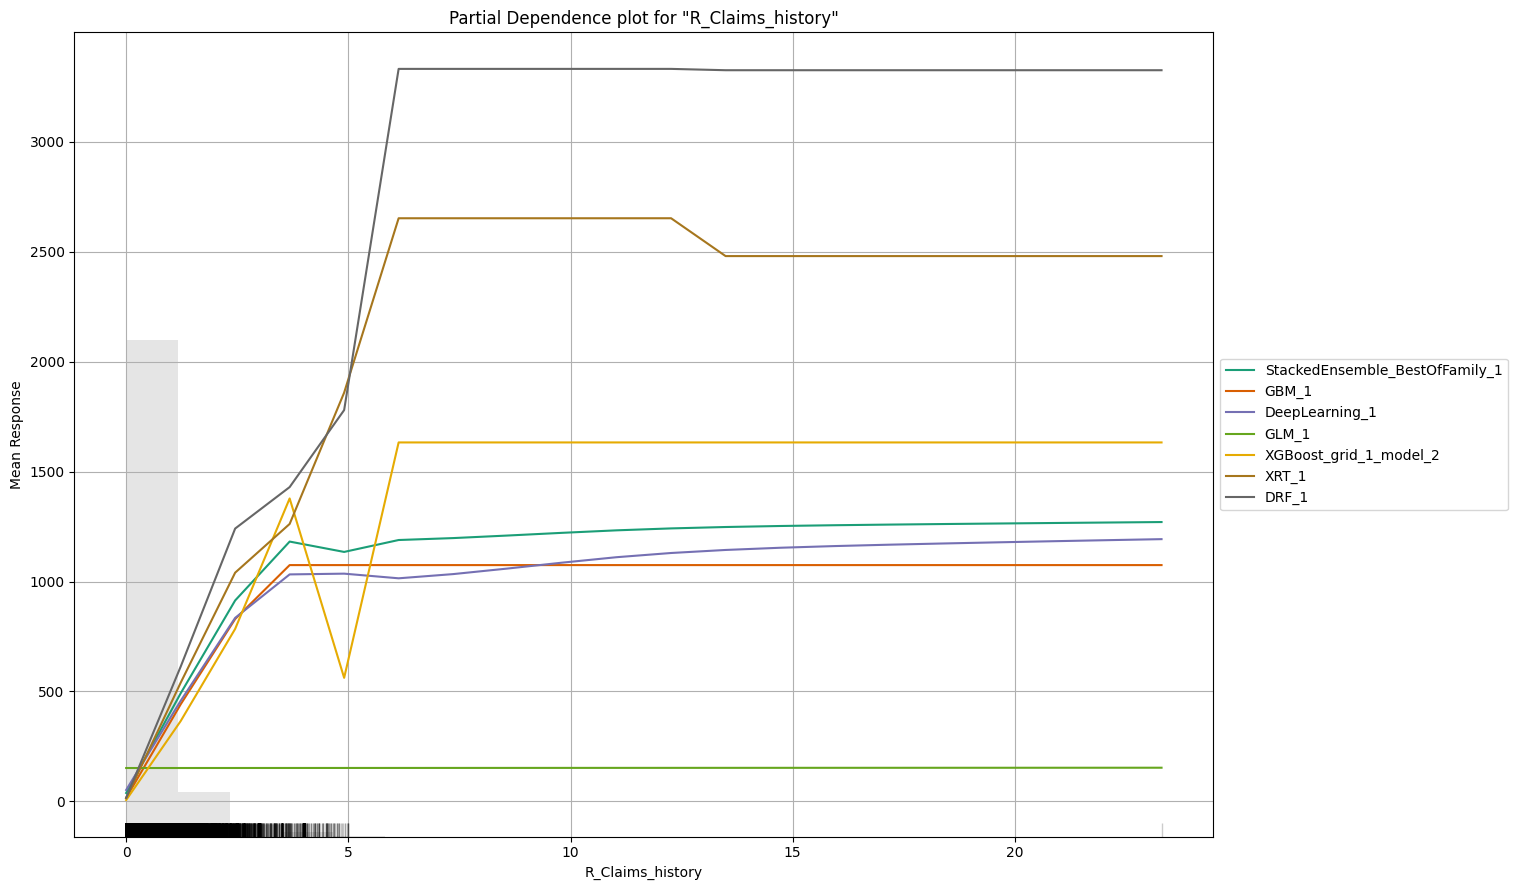

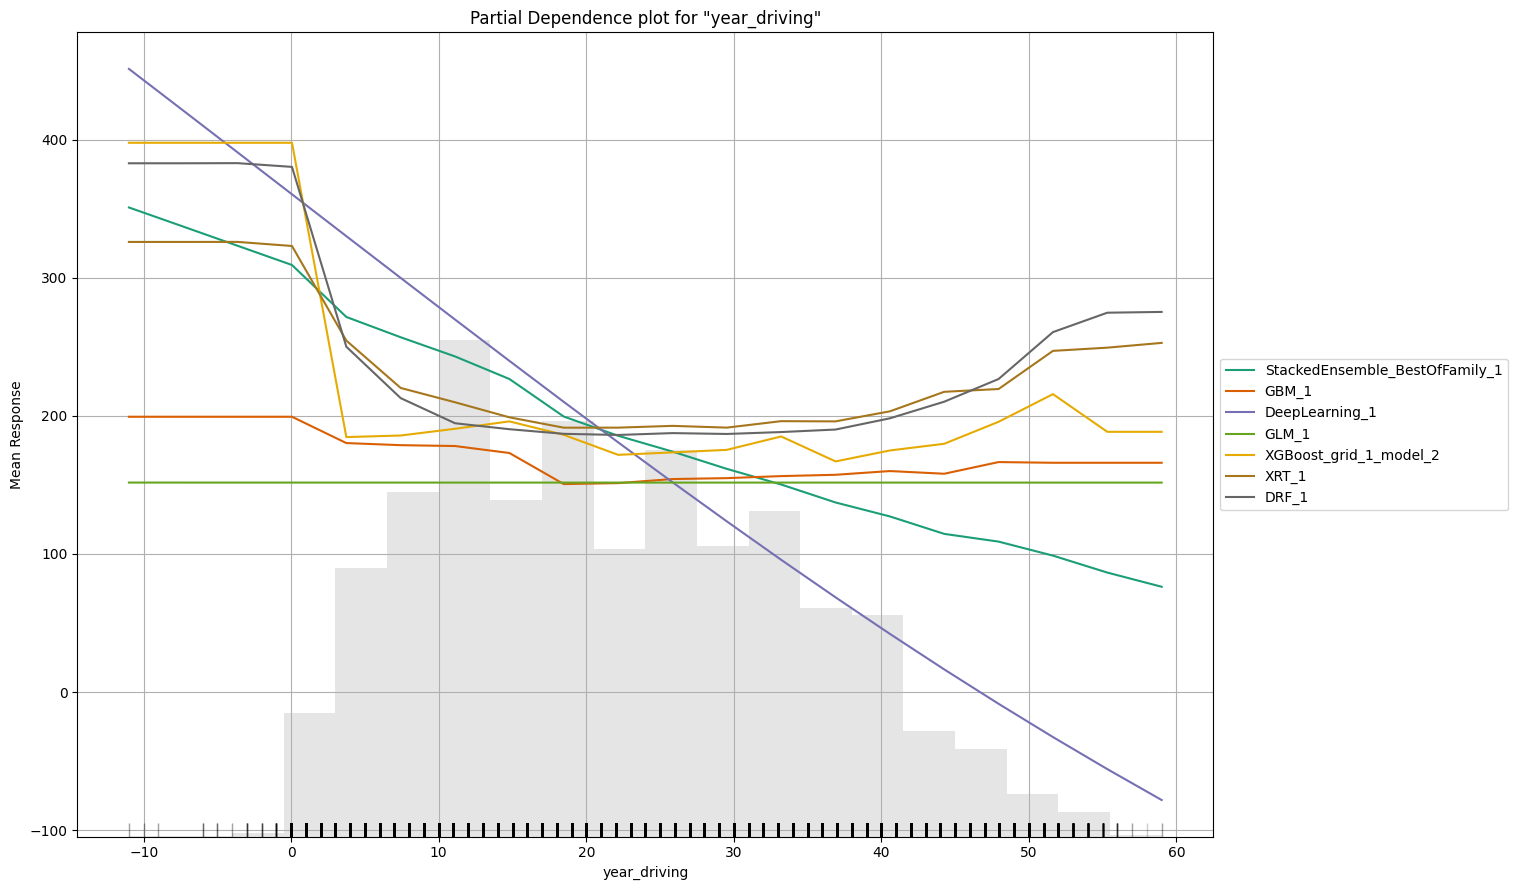

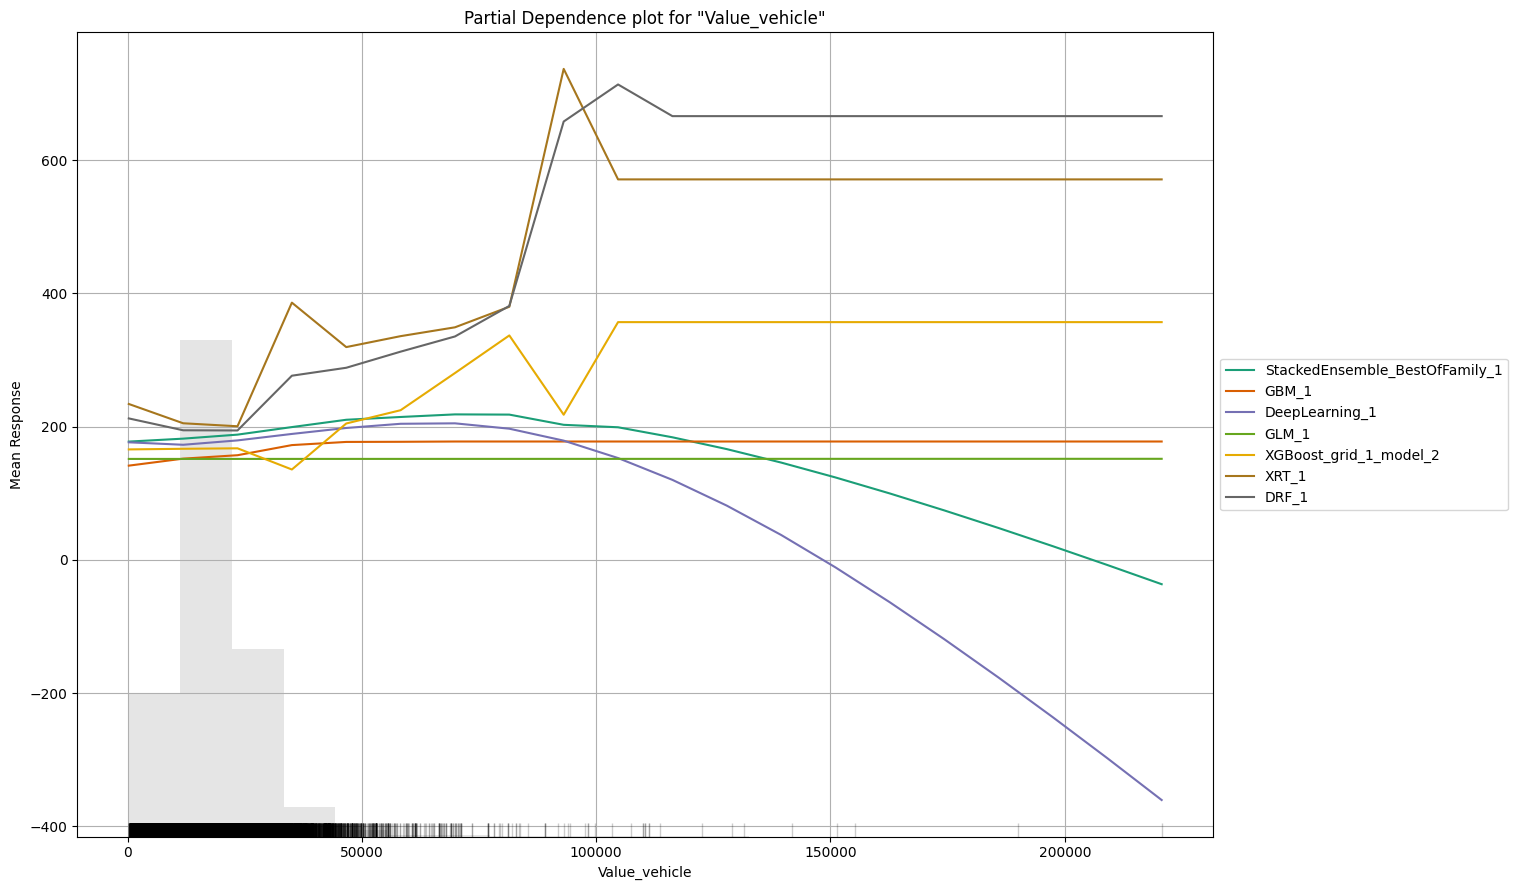

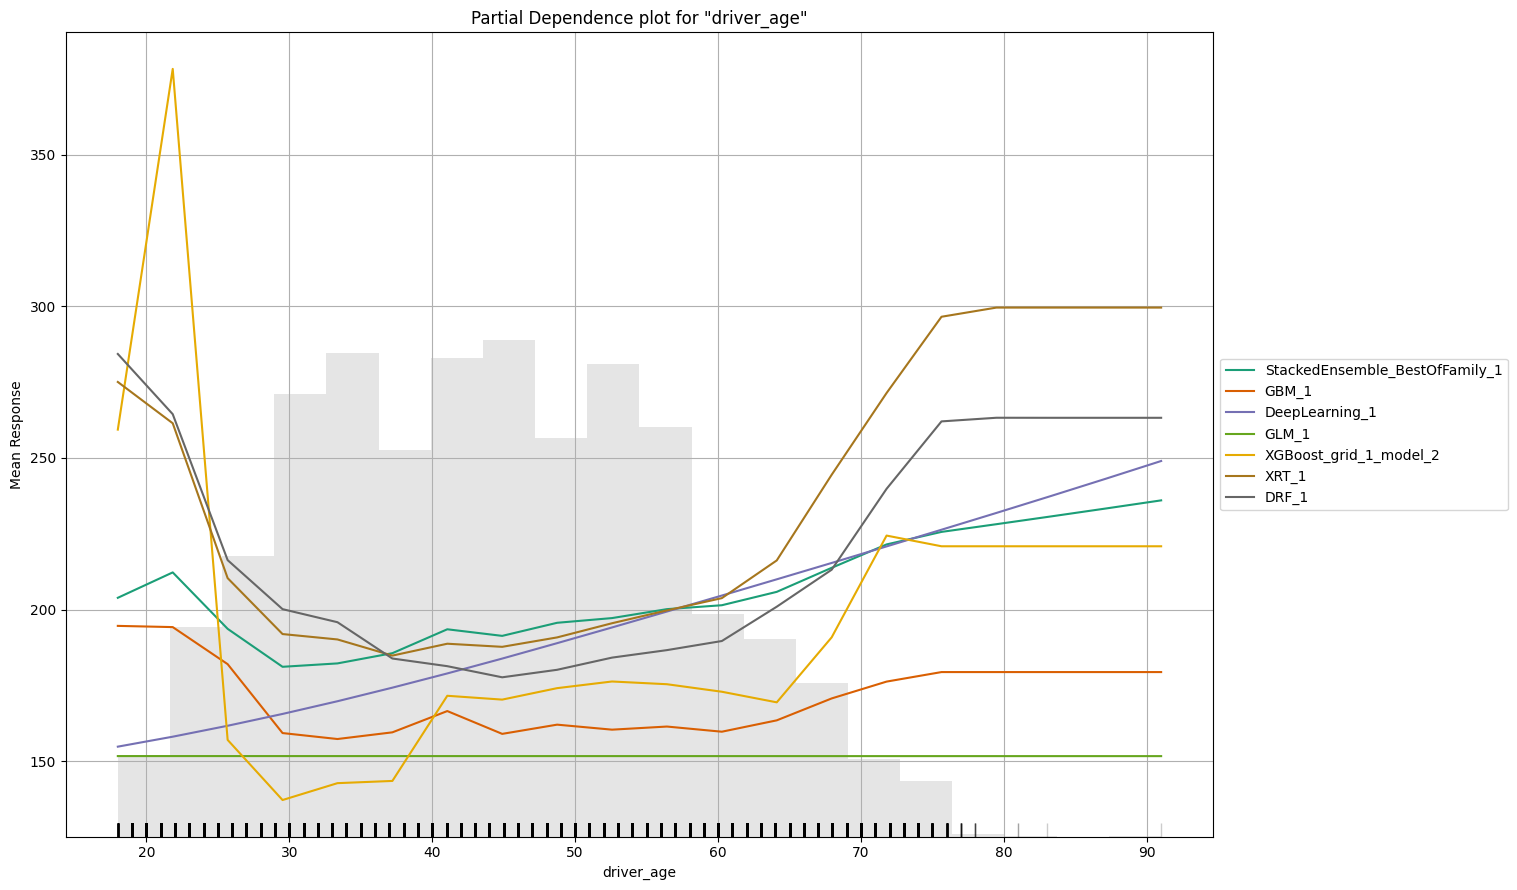

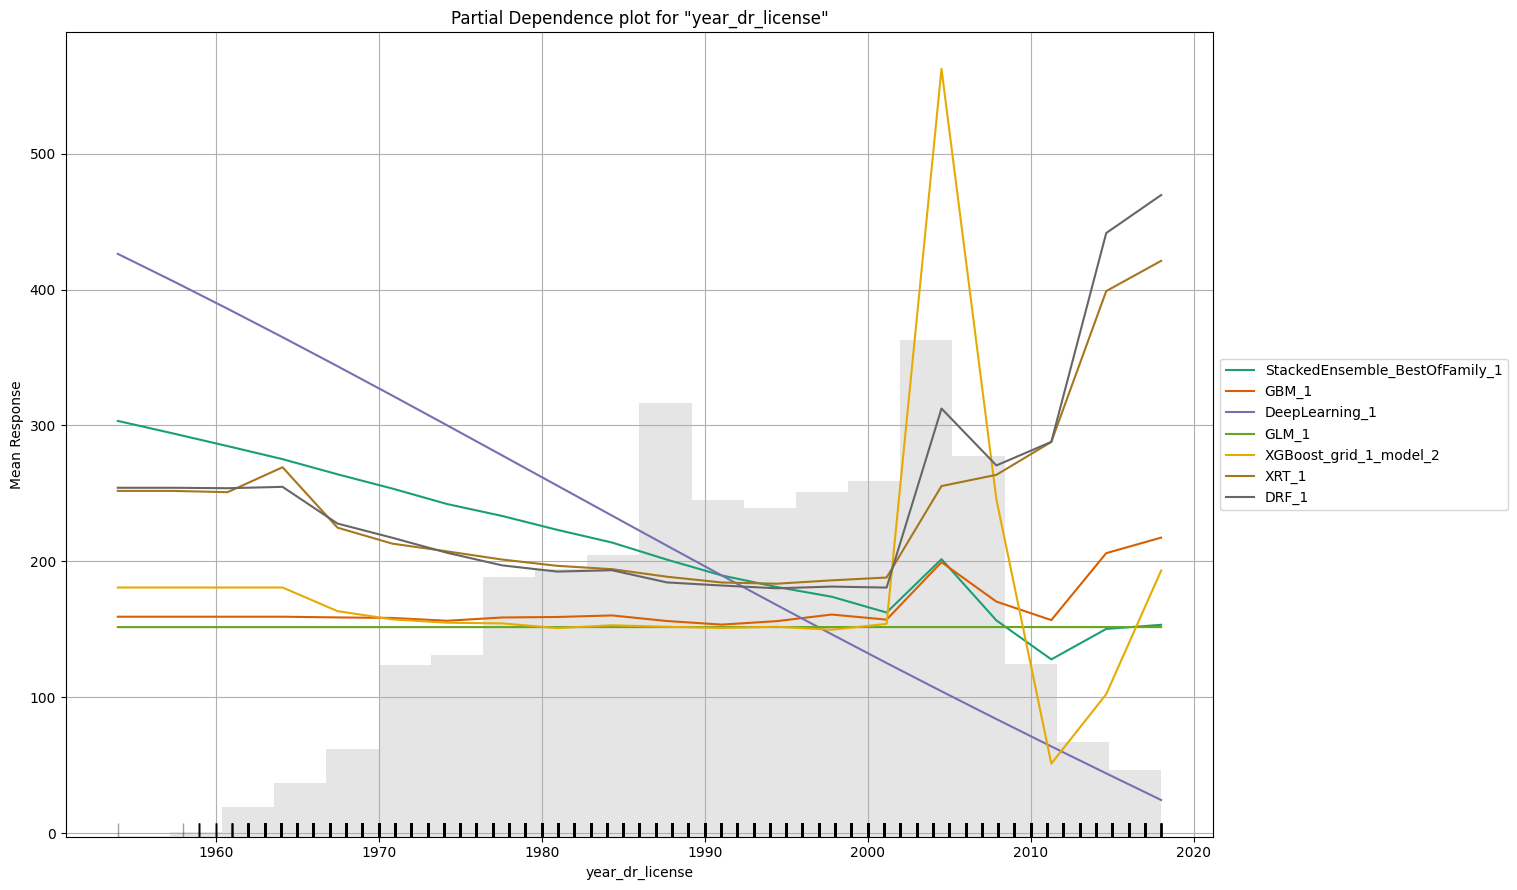

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

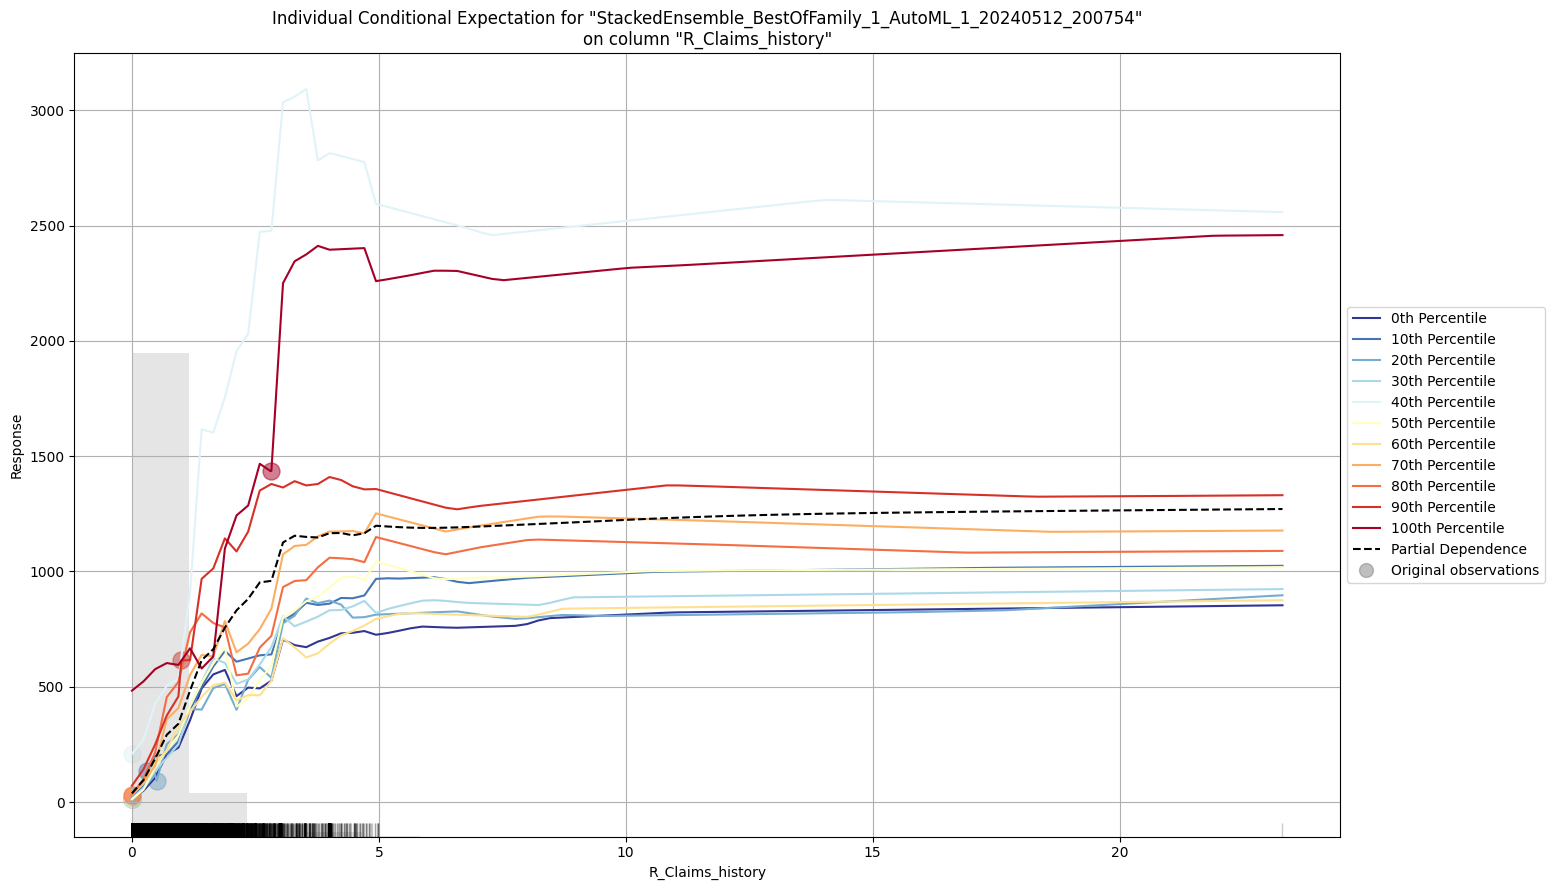

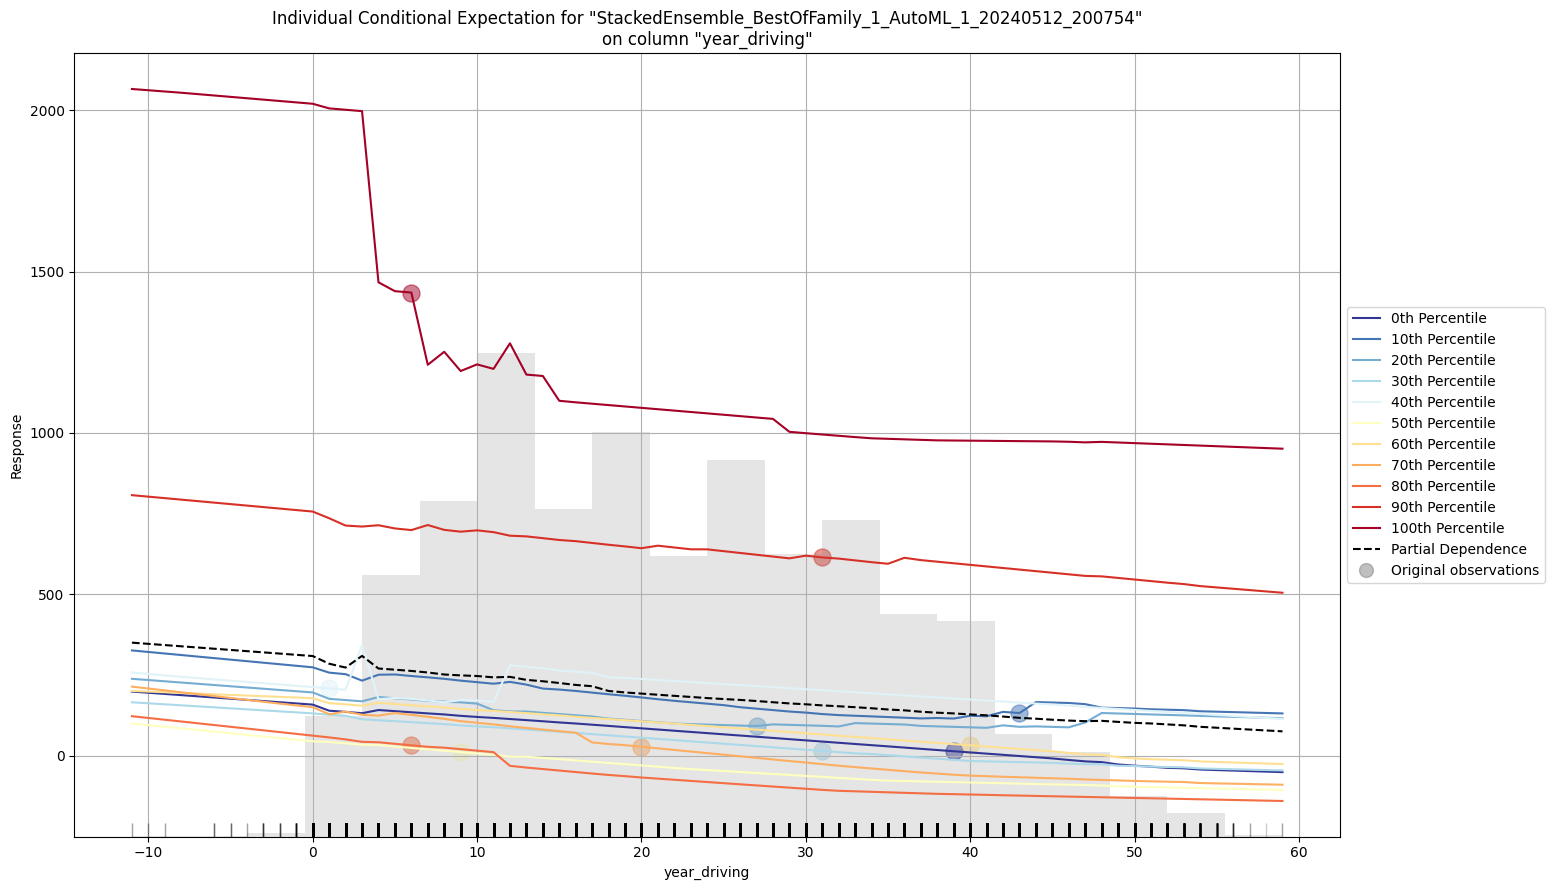

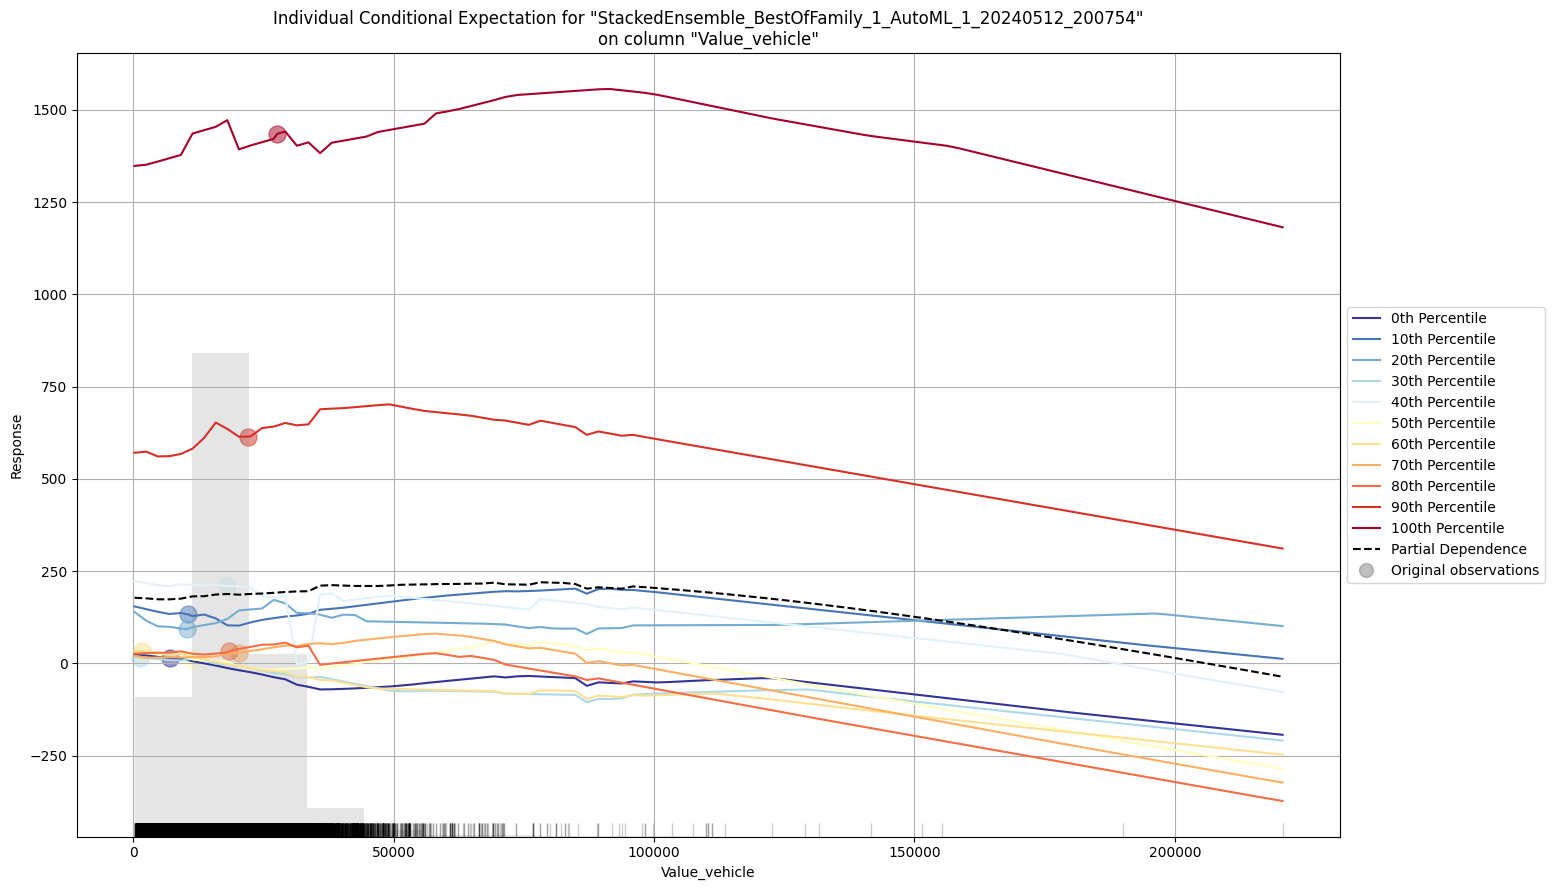

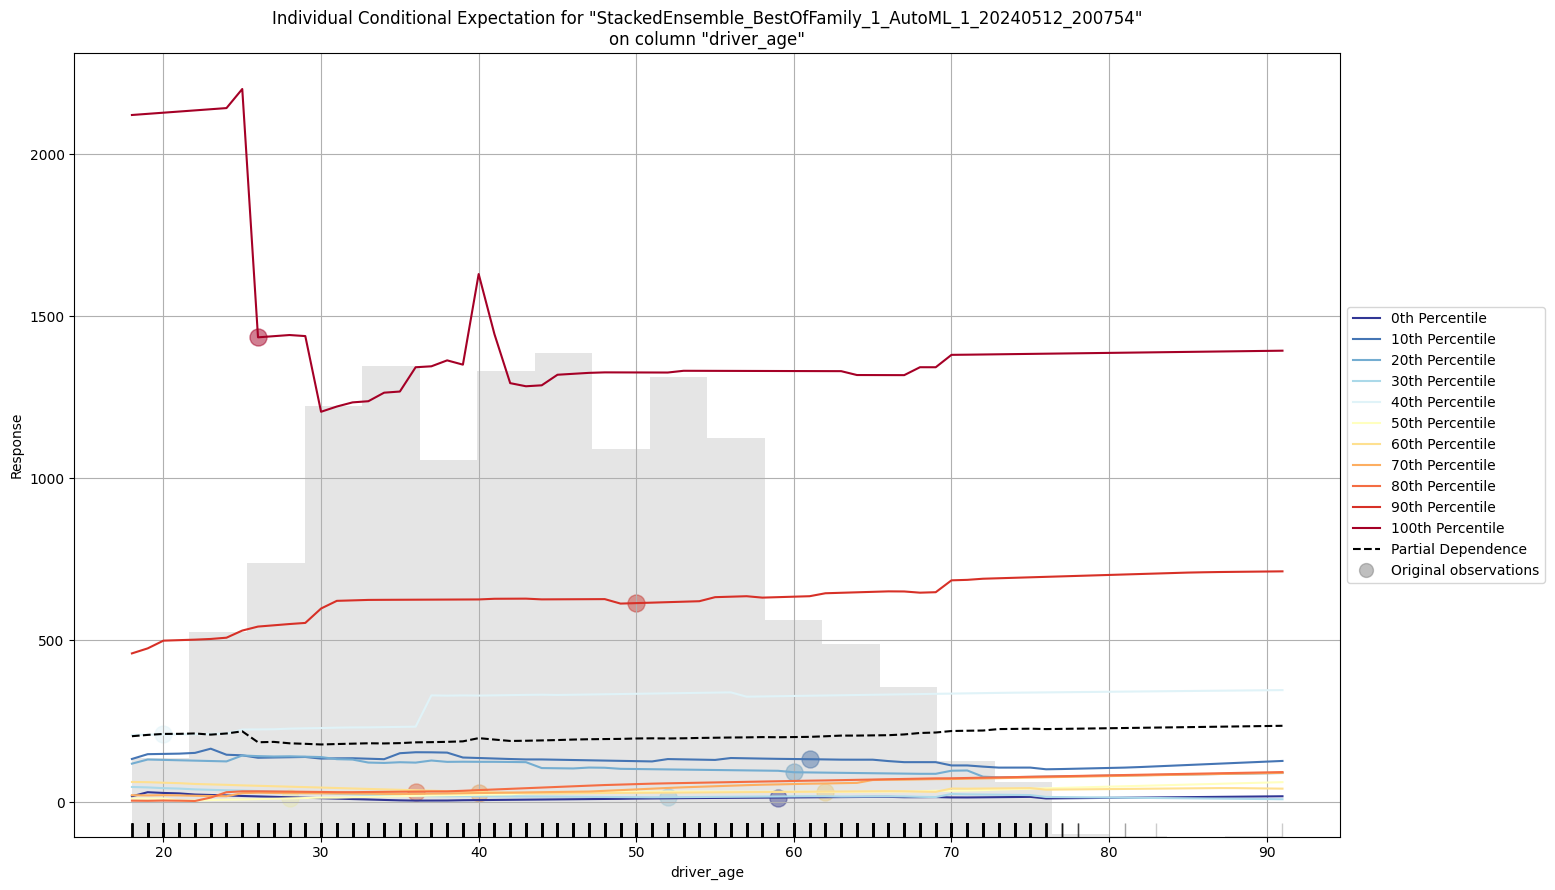

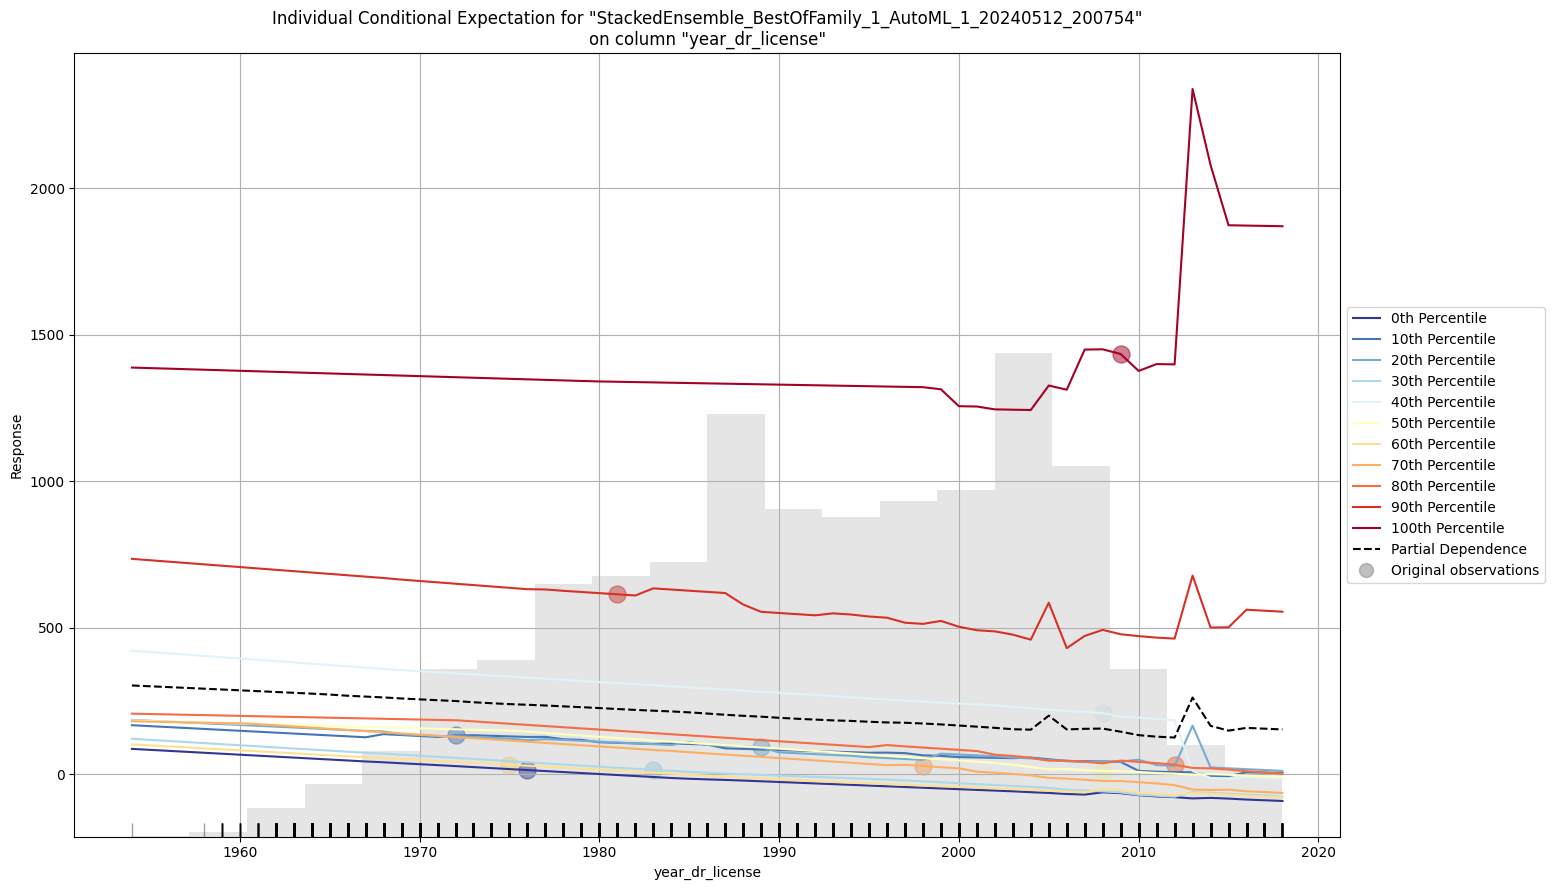

In [10]:
exa = aml.explain(test)